## Author : Shreyansh_Gupta

- Pre-Trained Model Used : Convnext_tiny
- Data Augmentation Used

In [1]:
!git clone https://github.com/Akasxh/Terrain-Recognition.git

Cloning into 'Terrain-Recognition'...
remote: Enumerating objects: 28357, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 28357 (delta 93), reused 57 (delta 54), pack-reused 28250 (from 1)
Receiving objects: 100% (28357/28357), 1.33 GiB | 20.75 MiB/s, done.
Resolving deltas: 100% (156/156), done.
Updating files: 100% (10541/10541), done.


In [2]:
try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

In [23]:
import os
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CyclicLR
import torch.nn as nn
import torch.optim as optim
from timm import create_model
from tqdm.auto import tqdm
import torch
from PIL import Image

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Define the directory paths (replace with your dataset paths)
train_dir = '/content/Terrain-Recognition/Data Main/Training Data' # Training Data Path
test_dir = '/content/Terrain-Recognition/Data Main/Testing Data'  #Testing Data Path

# Define image transformations for training and testing
image_size = 224  # Size for ConvNeXt Base input

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize to 224x224
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for ConvNeXt
])

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for ConvNeXt
])

# Create datasets and data loaders
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count())
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count())

In [6]:
# Load the pre-trained ConvNeXt Base model with pretrained weights
model = models.convnext_tiny(weights='IMAGENET1K_V1')  # Using pretrained weights

# Freeze all layers in the model
for param in model.parameters():
    param.requires_grad = False

# Modify the final classification layer to match 5 output classes
num_ftrs = model.classifier[2].in_features  # Access the last layer in the classifier
model.classifier[2] = nn.Linear(num_ftrs, 5)  # Change to 5 output classes

# Ensure only the last layer's weights are trainable
for param in model.classifier[2].parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 141MB/s]


In [7]:
# Print model summary
image_size = 224  # or your desired input size
# Print the summary of the model with input and output shapes per layer
summary(model,
        input_size=(32, 3, image_size, image_size),
        device=device,
        verbose=True,     # Enable verbose mode for detailed output
        col_names=["input_size", "output_size", "num_params", "trainable"])  # Specify columns to display

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
ConvNeXt                                      [32, 3, 224, 224]         [32, 5]                   --                        Partial
├─Sequential: 1-1                             [32, 3, 224, 224]         [32, 768, 7, 7]           --                        False
│    └─Conv2dNormActivation: 2-1              [32, 3, 224, 224]         [32, 96, 56, 56]          --                        False
│    │    └─Conv2d: 3-1                       [32, 3, 224, 224]         [32, 96, 56, 56]          (4,704)                   False
│    │    └─LayerNorm2d: 3-2                  [32, 96, 56, 56]          [32, 96, 56, 56]          (192)                     False
│    └─Sequential: 2-2                        [32, 96, 56, 56]          [32, 96, 56, 56]          --                        False
│    │    └─CNBlock: 3-3                      [32, 96, 56, 56]          [32, 96, 56,

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
ConvNeXt                                      [32, 3, 224, 224]         [32, 5]                   --                        Partial
├─Sequential: 1-1                             [32, 3, 224, 224]         [32, 768, 7, 7]           --                        False
│    └─Conv2dNormActivation: 2-1              [32, 3, 224, 224]         [32, 96, 56, 56]          --                        False
│    │    └─Conv2d: 3-1                       [32, 3, 224, 224]         [32, 96, 56, 56]          (4,704)                   False
│    │    └─LayerNorm2d: 3-2                  [32, 96, 56, 56]          [32, 96, 56, 56]          (192)                     False
│    └─Sequential: 2-2                        [32, 96, 56, 56]          [32, 96, 56, 56]          --                        False
│    │    └─CNBlock: 3-3                      [32, 96, 56, 56]          [32, 96, 56,

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define loss function and optimizer with a lower learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0008)  # Initial learning rate for CyclicLR

# Define CyclicLR scheduler
scheduler = CyclicLR(
    optimizer,
    base_lr=0.0008,
    max_lr=0.001,
    step_size_up=2000,
    step_size_down=2000,
    mode='triangular2'
)

# Training and evaluation functions
def train_step(model, dataloader, loss_fn, optimizer, scheduler, device):
    model.train()
    train_loss, train_acc = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        train_acc += (y_pred.argmax(1) == y).sum().item() / len(y)
    return train_loss / len(dataloader), train_acc / len(dataloader)

def test_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            test_acc += (y_pred.argmax(1) == y).sum().item() / len(y)
    return test_loss / len(dataloader), test_acc / len(dataloader)

# Lists to store training and testing metrics
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# Training loop
epochs = 6
for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_loader, criterion, optimizer, scheduler, device)
    test_loss, test_acc = test_step(model, test_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")



 17%|█▋        | 1/6 [01:24<07:01, 84.27s/it]

Epoch 1/6:
  Train Loss: 0.3014, Train Acc: 0.8964
  Test Loss: 0.2392, Test Acc: 0.9098


 33%|███▎      | 2/6 [02:44<05:28, 82.10s/it]

Epoch 2/6:
  Train Loss: 0.2928, Train Acc: 0.9033
  Test Loss: 0.2283, Test Acc: 0.9148


 50%|█████     | 3/6 [04:05<04:04, 81.41s/it]

Epoch 3/6:
  Train Loss: 0.2843, Train Acc: 0.9025
  Test Loss: 0.2284, Test Acc: 0.9148


 67%|██████▋   | 4/6 [05:25<02:41, 80.76s/it]

Epoch 4/6:
  Train Loss: 0.2838, Train Acc: 0.9006
  Test Loss: 0.2168, Test Acc: 0.9211


 83%|████████▎ | 5/6 [06:44<01:20, 80.37s/it]

Epoch 5/6:
  Train Loss: 0.2843, Train Acc: 0.9001
  Test Loss: 0.2304, Test Acc: 0.9121


100%|██████████| 6/6 [08:04<00:00, 80.78s/it]

Epoch 6/6:
  Train Loss: 0.2864, Train Acc: 0.8999
  Test Loss: 0.2133, Test Acc: 0.9172


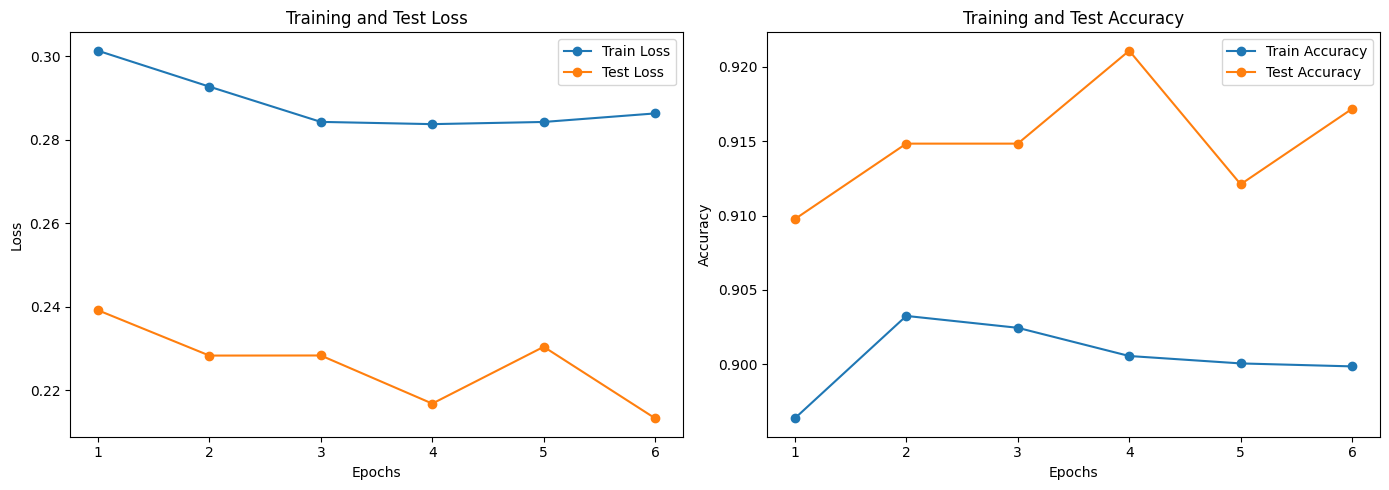

In [12]:
# Plotting
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(14, 5))

# Plot Training and Test Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_range, test_losses, label='Test Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Plot Training and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


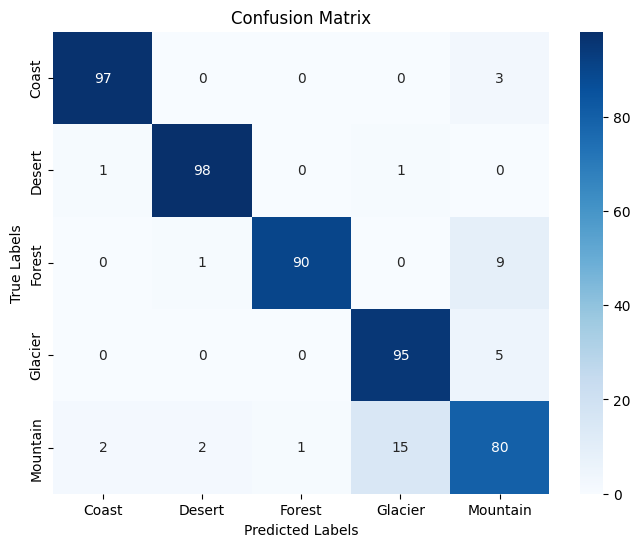

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np

# After the training loop, compute and plot the confusion matrix
def plot_confusion_matrix(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    # Collect all predictions and true labels
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            all_preds.extend(y_pred.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot using seaborn heatmap for better visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Define the class names for your dataset
class_names = train_dataset.classes

# Plot confusion matrix after all epochs
plot_confusion_matrix(model, test_loader, device, class_names)


In [14]:
# Save the model
torch.save(model.state_dict(), 'convnext_tiny_model.pth')  # Save only the state_dict
print("Model saved as convnext_tiny_model.pth")

Model saved as convnext_tiny_model.pth


In [22]:
# Create the model instance
model = torchvision.models.convnext_tiny(weights='IMAGENET1K_V1')  # Recreate the model structure
num_ftrs = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_ftrs, 5)

# Load the saved state dict
model.load_state_dict(torch.load('/content/convnext_tiny_model.pth'))

model = model.to(device)
model.eval()  # Set the model to evaluation mode
print("Model loaded successfully")

Model loaded successfully


<ipython-input-22-cc5bde4f302f>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/convnext_tiny_model.pth'))


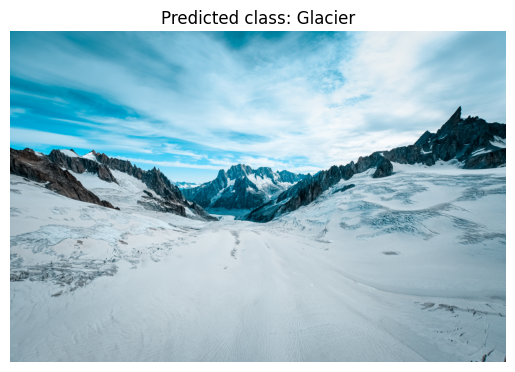

In [24]:
# Load and preprocess your custom image
image_path = '/content/beautiful-wide-shot-ruth-glaciers-covered-snow-blue-sky-with-white-clouds.jpg'  # Replace with your image path
image = Image.open(image_path).convert('RGB')
image_tensor = test_transform(image).unsqueeze(0)

model.to(device)
image_tensor = image_tensor.to(device)

# Make predictions
with torch.no_grad():
    outputs = model(image_tensor)

_, predicted_class = torch.max(outputs, 1)

predicted_label = class_names[predicted_class.item()]

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title(f'Predicted class: {predicted_label}')
plt.show()
